# Fanal, a neutrino-less beta decay experiment 

## An open exercise

## Calibration


### USC, Master de Física, Física de Partícula II


J. A. Hernando-Morata, 

with the help of J. Muñoz, J. M. Benlloch, B. Palmeiro, G. Díaz

February 2021


In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as constants

import warnings
warnings.filterwarnings('ignore')

In [3]:
# REMEMBER TO ADD THE FOLDER TO PYTHONPATH
import os
import sys
dirpath = os.getcwd()[:-9]
print('add path to PYTHONPATH : ', dirpath)
sys.path.insert(0, os.path.abspath(dirpath))

add path to PYTHONPATH :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal


In [4]:
import core.pltext  as pltext   # extensions for plotting histograms
import core.hfit    as hfit     # extension to fit histograms
import core.utils   as ut       # generic utilities
import ana.fanal    as fn       # analysis functions specific to fanal
import     collpars as collpars # collaboration specific parameters
pltext.style()

## Indications

### Objective

**Estimate the energy resolution** and **the energy scale of the detector**. For that, we will fit some peaks a 208Tl calibration sample to its know tabulated energy.

### Tasks:

   * Open the data file (HDF) and access the mock calibration data (cal) obtained with a 208Tl source.

   * Fit the energy of the main track (track0) to the main photo-peak (2.615 MeV) and double-scape peak.
   
   * Fit the energy of the secon track (track1) to other Tl gamma lines
   
   * Calibrate the measured energy of the peacks with respect the tabulated energy.

### Notes:

   * The main photo-peak is at 2.615 MeV. This peak can suffer Compton, Bremsstrahlung and pear production. A double-scape peak is expected at 2.615 - 2 * 511 keV. 
  
   * There are other minor 208Tl gamma lines at 860, 583 and 511 keV. 
  
   * Sometimes the photo-peak is produced with an associated 126Xe X-ray of 30 keV.

## Main Parameters

In [5]:
coll   = 'test_alpha'
erange = fn.erange
eroi   = fn.eroi 
eblob2 = fn.eblob2

print('Data From               : {:s}'.format(coll))
print('Energy range            : ({:6.3f}, {:6.3f}) MeV'.format(*erange))
print('Blob-2 energy threshold : {:6.3f} MeV'.format(eblob2))
print('Energy RoI range        : ({:6.3f}, {:6.3f}) MeV'.format(*eroi))

Data From               : test_alpha
Energy range            : ( 2.400,  2.700) MeV
Blob-2 energy threshold :  0.400 MeV
Energy RoI range        : ( 2.430,  2.480) MeV


## Access the data

In [6]:
dirpath = '/Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal/data/'
filename = 'fanal_' + coll + '.h5'
print('Data path and filename : ', dirpath + filename)

calib = pd.read_hdf(dirpath + filename, key = 'data/tl208')

Data path and filename :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal/data/fanal_test_alpha.h5


### list of variables



In [7]:
calib

,E,num_tracks,num_voxels,track0_E,track0_voxels,track0_length,blob1_E,blob2_E,track1_E,track1_voxels,track1_length
564546,2.615397,2.0,27,2.312862,26.0,144.587124,NaN,NaN,0.302535,1.0,0.000000
376309,2.604736,5.0,24,1.741889,20.0,90.631288,NaN,NaN,0.481098,1.0,0.000000
469518,2.393022,2.0,27,2.360668,26.0,140.393303,NaN,NaN,0.032353,1.0,0.000000
360901,2.473315,2.0,29,2.284131,28.0,122.871850,NaN,NaN,0.189184,1.0,0.000000
729146,2.436927,5.0,29,1.614206,23.0,108.759626,NaN,NaN,0.528430,2.0,9.900239
...,...,...,...,...,...,...,...,...,...,...,...
795608,3.026290,5.0,34,2.161288,26.0,134.215376,NaN,NaN,0.425306,1.0,0.000000
448958,2.618126,4.0,21,1.971669,16.0,93.781639,NaN,NaN,0.300519,1.0,0.000000
614419,2.622842,3.0,28,2.047454,25.0,117.405271,NaN,NaN,0.305801,2.0,9.821184
244986,2.434591,6.0,29,1.645987,22.0,115.888528,NaN,NaN,0.234870,1.0,0.000000


## Histogram the variables

We are drawing the variables only in the relevant range (2.6, 2.8 MeV)

In [8]:
#pltext.df_inspect(calib, ncolumns = 3)

## Energy calibration, identifying the peaks

In [9]:
# utitility function
def efit(enes, bins, erange, guess = None):
    guess  = (len(enes), np.mean(enes), 20., 10., 0.) if guess is None else guess
    sel    = ut.in_range(enes, erange)
    pars, cpars = pltext.hfit(enes[sel], bins, fun = 'gausline', guess = guess, range = erange);
    return pars, cpars

### Photo-peak and double-escape

Study the energy of the track-0.

Fit the photo-peak and the double-escape peak

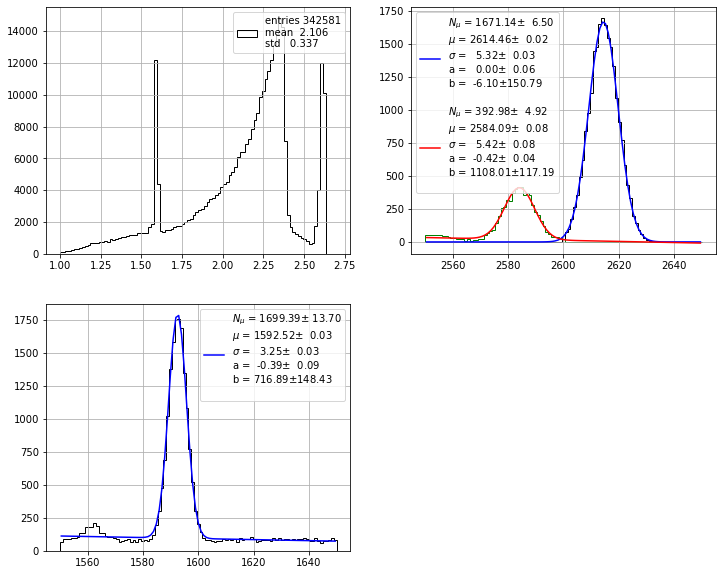

In [10]:
enes   = 1e3 * ut.remove_nan(calib.track0_E.values) # energy in keV and remove NaN

calpars = []

subplot = pltext.canvas(4)

subplot(1)
pltext.hist(calib.track0_E, 100, range = (1., 2.7));

subplot(2)
erange = (2600, 2650) 
guess  = (1e3, 2615, 20., 20., 0.)
bins   = np.linspace(2550, 2650, 100) 
pars, cpars = efit(enes, bins, erange, guess);
calpars.append( (pars, cpars))
erange = (2550-50, 2650 - 50) 
guess  = (1e2, 2615 - 50, 20., 20., 0.)
pars, cpars  = efit(enes, bins, erange, guess);


subplot(3)
erange = (1550, 1650) 
bins   = np.linspace(*erange, 100) 
guess  = (1e3, 1560, 20., 20., 0.)
pars, cpars = efit(enes, bins, erange, guess)
calpars.append( (pars, cpars))

## Other Tl peaks

Study the energy of track-1. 

Identify the peaks.

Fit then to a gaussian.

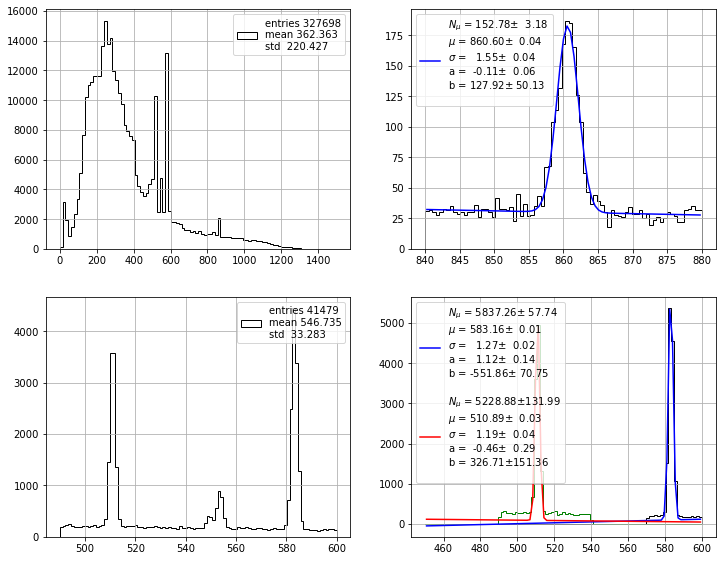

In [11]:
enes   = 1e3 * ut.remove_nan(calib.track1_E.values) # energy in keV and remove NaN

subplot = pltext.canvas(6)

subplot(1)
pltext.hist(enes, 100, range = (0., 1500.));

subplot(2)
erange = (840, 880.) 
bins   = np.linspace(*erange, 80) 
guess  = (1e2, 860, 5., 0., 0.)
pars, cpars = efit(enes, bins, erange, guess)
calpars.append( (pars, cpars))


subplot(3)
xrange  = (490., 600.) 
pltext.hist(enes, 100, range = xrange)

subplot(4)
erange = (570, 600.) 
bins   = np.linspace(450, 600, 100) 
guess  = (1e2, 585, 5., 0., 0.)
pars, cpars = efit(enes, bins, erange, guess)
calpars.append( (pars, cpars))

erange = (490, 540.) 
guess  = (1e2, 511, 5., 0., 0.)
pars, cpars = efit(enes, bins, erange, guess)
calpars.append( (pars, cpars))

## Energy Scale calibration

Relate the measured peaks positions to the tabulated one. 

Fit to a line.

If there are deviation respect unity use this line to calibrate your detector.


In [12]:
xvals  = np.array([511., 583., 860., 2615. - 2 * 511, 2615.])
calpars.reverse()
yvals  = np.array([val[0][1] for val in calpars])
eyvals = np.array([val[1][1] for val in calpars])

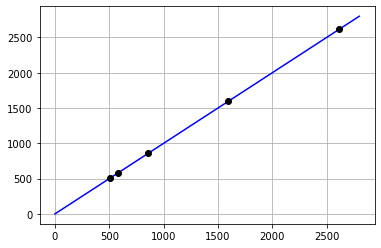

In [13]:
plt.errorbar(xvals, yvals, yerr = 1.5* eyvals, ls = '', marker = 'o')
xs = np.linspace(0., 2800, 100)
plt.plot(xs, xs); plt.grid();

In [14]:
import scipy.optimize as optimize

def fline(x, a, b):
    return a * x + b

#par, cov = optimize.curve_fit(fline, xvals, yvals, sigma = 1.5 * eyvals, p0 = (1., 0.), absolute_sigma = True)

par, cov = optimize.curve_fit(fline, xvals, yvals, sigma = 1.5* eyvals, p0 = (1., 0.))
chi2     = np.sum(((fline(xvals, *par) - yvals))**2)
epar = np.sqrt(np.diag(cov)) 
print(r'calibration scale     : {0:6.4f} +/- {1:6.4f}'.format(par[0], epar[0]))
print(r'calibration threshold : {0:6.4f} +/- {1:6.4f}'.format(par[1], epar[1]))
print(r'resolution near  Qbb  : {0:6.3f} % FWHM '.format(235. * abs(calpars[-1][0][2])/calpars[-1][0][1]))

calibration scale     : 0.9996 +/- 0.0001
calibration threshold : 0.3636 +/- 0.1919
resolution near  Qbb  :  0.478 % FWHM 


### Additional notes

These are the decay diagrams of 214Bi and 208Tl. 

Several lines can be observed in the total energy and track-0 and track-1 energies. 

Notice that the 1.615 MeV gamma can produrce electron-positron pairs and a double-scape peak when the photons produced by the positron capture scape the detector, the double-scape peak has an energy of $1.615 - 2 \; 0.511$ MeV


<img src= "../img/214-Bi-and-208-Tl-decay-diagrams.png" width="800" height="400">